In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('lqcd')

In [4]:
class FeedforwardNN(nn.Module):

    def __init__(self, hidden_sizes:list, dropout:float=0.0):
        super(FeedforwardNN, self).__init__()
        layers = []
        input_size = 7  # Number of input features

        current_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            current_size = hidden_size

        layers.append(nn.Linear(current_size, 1))
        layers.append(nn.Sigmoid())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    


In [3]:
X_train = np.load("./data/Xe_train.npy")
y_train = np.load("./data/ye_train.npy")
X_test = np.load("./data/Xe_test.npy")

Y_train = np.zeros((y_train.shape[0], 2))
for i in range(y_train.shape[0]):
    Y_train[i, y_train[i]] = 1.0

print(X_train.shape)

(891, 7)


Epoch 1/4, Loss: 0.4622
Epoch 2/4, Loss: 0.2232
Epoch 3/4, Loss: 0.4096
Epoch 4/4, Loss: 0.5880


Text(0, 0.5, 'Loss')

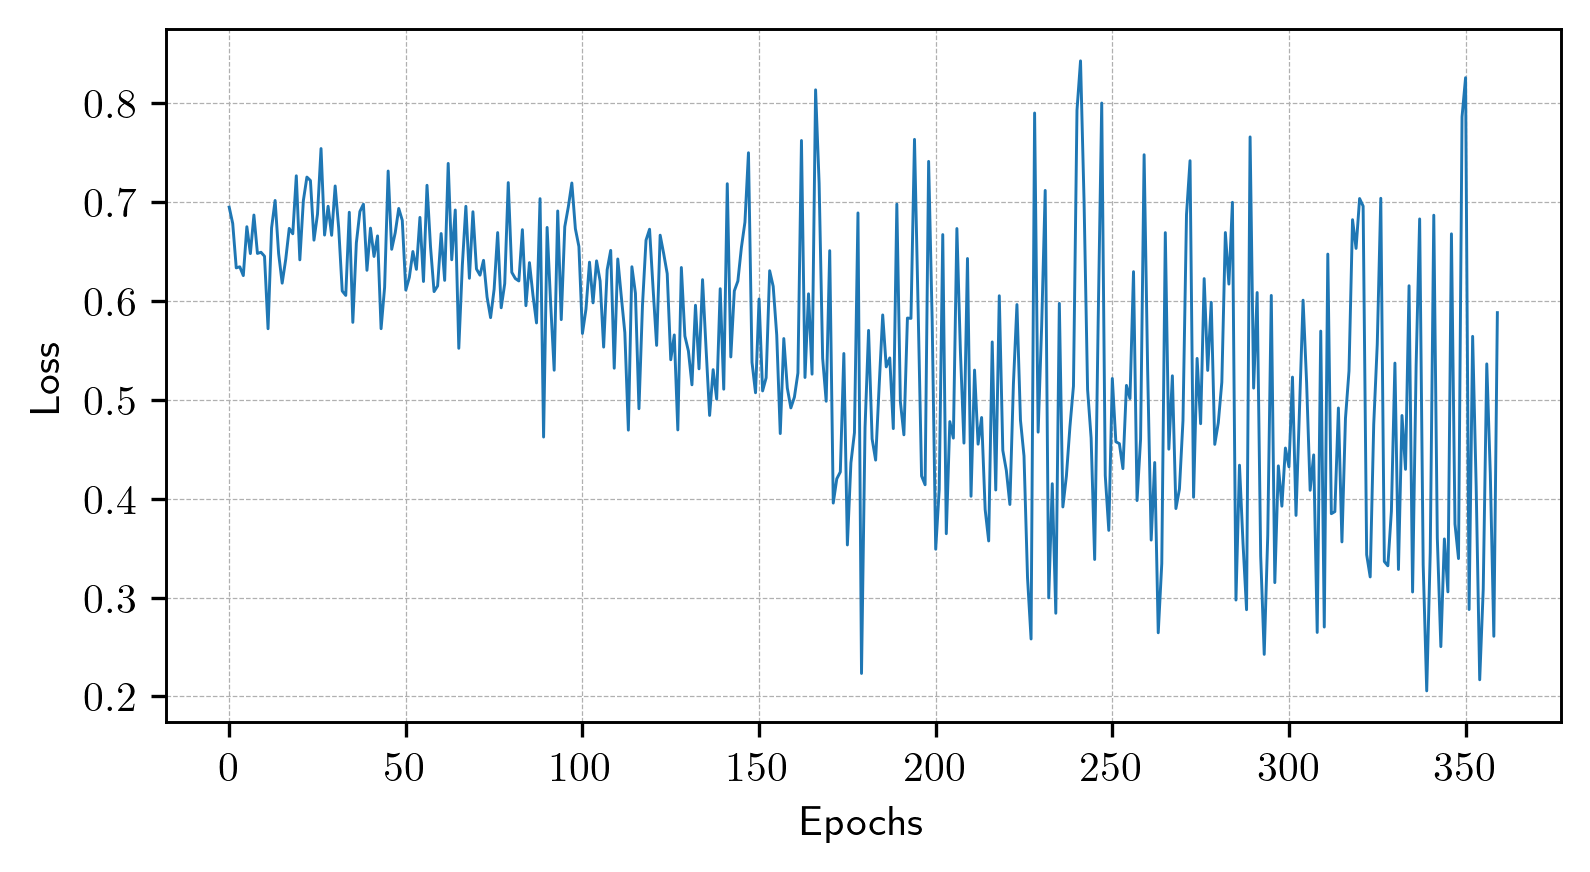

In [18]:
dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

model = FeedforwardNN(hidden_sizes=[32,16], dropout=0.1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 4


loss_values = []    
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())

    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


fig, ax = plt.subplots()
ax.plot(loss_values, label='Training Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

In [14]:
# Evaluate the model
model.eval()

FeedforwardNN(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [21]:
estimate = np.round(model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy(), 0)

import pandas as pd 

td = pd.read_csv("./data/test.csv")

rd = pd.DataFrame({"PassengerID": td['PassengerId'], "Survived": estimate.flatten().astype(int)})
rd.to_csv("./data/result_feedforward.csv", index=False)